**Gaussian processes** model a latent function based on a finite set of (noisy) observations of the function: $$ \mathcal{D} = \left\{ \left(x_i,y_i\right)\right\}_{i=1}^n.$$ A key is that our choice of mean and kernel imposes smoothness conditions on the functions. The kernel specifically specifies the correlations of the $y_i$ as a function of the Euclidean distances of the $x_i$. Thus, nearby $x_i$ will have highly-correlated $y_i$.

The Gaussian process prior over the function values is $$ \left. f\left(x\right) \, \middle| \, \theta \right. \sim \text{GP}\left(m_{\theta}\left(x\right), k_{\theta}\left(x,x'\right)\right) $$ which is really a normal distribution. This is called a prior (though it depends on the given data) because it is a distribution over the unknown functions.

Our prior knowledge goes a little bit into our choice of $m_{\theta}$ and $k_{\theta}$. In the Bayesian formulation, we can incorporate more information as a prior over the hyperparameters $\theta$. 

The Gaussian process prior is not a multivariate Gaussian. It has a mean and covariance function. The covariance function is of the form $k\left(x,x'\right)$ where $x$ are the function values and $x'$ are all possible values in the input domain. Thus, the covariance describes the correlation of a point with all other points in the input domain. The input domains are generally infinite, so the Gaussian process prior is effectively an infinite-dimensional Gaussian random variable.

Based on this infinite nature of the Gaussian process prior, we can't simply sample from it to evaluate an entire function $f$. Instead, we restrict ourselves to a finite set of points $X$, often called *test points*. Then we want to find $$ y = f\left(X\right).$$ By the properties of Gaussians, if we marginalize on these test points, we obtain another Gaussian distribution $$ y \sim \mathcal{N}\left(m\left(X\right), k\left(X,X\right)\right) $$


In [7]:
using GaussianProcesses, Random, RDatasets, Distributions

Random.seed!(113355)

crabs = dataset("MASS", "crabs");
crabs = crabs[shuffle(1:size(crabs)[1]), :] # shuffle dataset

train = crabs[1:div(end,2), :];

y = Array{Bool}(undef, size(train)[1]);
y[train[:Sp] .== "B"] .= 0;
y[train[:Sp] .== "O"] .= 1;

X = convert(Array, train[:,4:end]);

# select mean, kernel, likelihood functions
mZero = MeanZero();
kern = Matern(3/2, zeros(5), 0.0);
lik = BernLik();

# fit the GP model using the general GP function (GPMC)
gp = GP(X', y, mZero, kern, lik)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:11
└ @ Core In[7]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:12
└ @ Core In[7]:12


GP Approximate object:
  Dim = 5
  Number of observations = 100
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Ard{Float64}, Params: [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0]
  Likelihood:
    Type: BernLik, Params: Any[]
  Input observations = 
[16.2 11.2 … 11.6 18.5; 13.3 10.0 … 9.1 14.6; … ; 41.7 26.9 … 28.4 42.0; 15.4 9.4 … 10.4 16.6]
  Output observations = Bool[0, 0, 0, 0, 1, 1, 0, 1, 1, 1  …  0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
  Log-posterior = -161.209

In [8]:
set_priors!(gp.kernel, [Distributions.Normal(0.0, 2.0) for i in 1:6])

6-element Array{Normal{Float64},1}:
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)
 Normal{Float64}(μ=0.0, σ=2.0)

In [10]:
# perform sampling
samples = mcmc(gp);# ϵ=0.01, nIter=10000, burn=1000, thin=10);

Number of iterations = 1000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 9.954000 
Number of function calls: 9955
Acceptance rate: 0.120000 


In [12]:
# assess the predictive accuracy
test = crabs[div(end,2)+1:end, :];
yTest = Array{Bool}(undef, size(test)[1]);
yTest[test[:Sp] .== "B" ] .= 0;
yTest[test[:Sp] .== "0" ] .= 1;
xTest = convert(Array, test[:, 4:end]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[12]:4
└ @ Core In[12]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[12]:5
└ @ Core In[12]:5


In [13]:
ymean = Array{Float64}(undef, size(samples,2), size(xTest,1));

for i in 1:size(samples,2)
    set_params!(gp, samples[:,i])

    update_target!(gp)

    ymean[i,:] = predict_y(gp, xTest')[1]
end

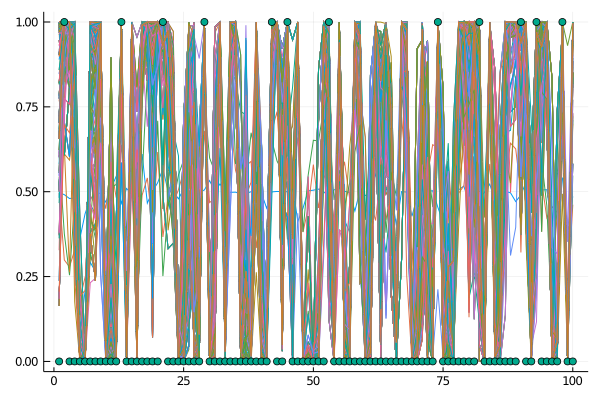

In [14]:
using Plots
gr()

plot(ymean', leg=false)
scatter!(yTest)


In [18]:
Random.seed!(13579);

n = 10; # number of training samples
x = 2*pi * rand(n); # predictors
y = sin.(x) + 0.05 * randn(n); # regressors

In [19]:
# select mean and covariance
mZero = MeanZero();
kern = SE(0.0, 0.0); # squared exponential kernel
logObsNoise = -1.0; #log std dev of observation noise_variance
gp = GP(x,y,mZero,kern,logObsNoise) # fit the GP

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SEIso{Float64}, Params: [0.0, 0.0]
  Input observations = 
[5.660719136818516 1.6722182706774558 … 6.089776396491339 3.394508945195908]
  Output observations = [-0.505286811809316, 1.0231226833435911, 0.6169549340093051, -0.777657908883248, -0.8754020230517494, 0.9297600226240434, -1.0452520359307873, -0.005437036283892797, -0.3017593563600969, -0.3646611892675245]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.719

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{LinearAlgebra.Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,SEIso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/dks0559531/.julia/packages/Plots/ViMfq/src/pipeline.jl:15


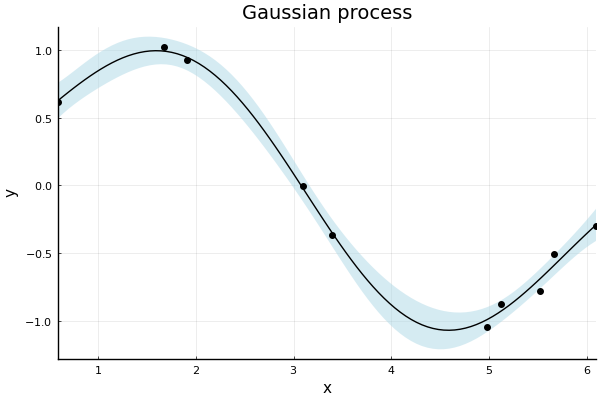

In [24]:
xp = 0:0.1:2*pi;
mu, sigma = predict_y(gp,x);

using Plots 
pyplot()
plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)


In [23]:
optimize!(gp) # optimize the parameters

 * Status: success

 * Candidate solution
    Minimizer: [-2.68e+00, 4.34e-01, -2.51e-01]
    Minimum:   -4.902989e-01

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-1.00e+00, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 9.48e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.53e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.59e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-13 ≰ 0.0e+00
    |g(x)|                 = 7.95e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    31
    ∇f(x) calls:   31


┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::GPE{LinearAlgebra.Adjoint{Float64,Array{Float64,1}},Array{Float64,1},MeanZero,SEIso{Float64},GaussianProcesses.FullCovariance,GaussianProcesses.IsotropicData{Array{Float64,2}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.Scalar{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots /Users/dks0559531/.julia/packages/Plots/ViMfq/src/pipeline.jl:15


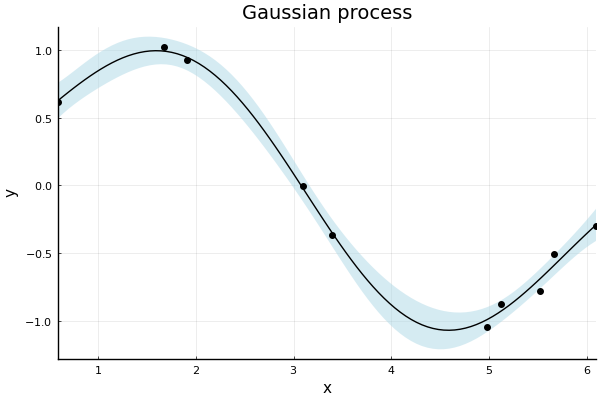

In [25]:
xp = 0:0.1:2*pi;
mu, sigma = predict_y(gp,x);

using Plots 
pyplot()
plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)


Number of iterations = 1000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 10.025000 
Number of function calls: 10026
Acceptance rate: 0.970000 


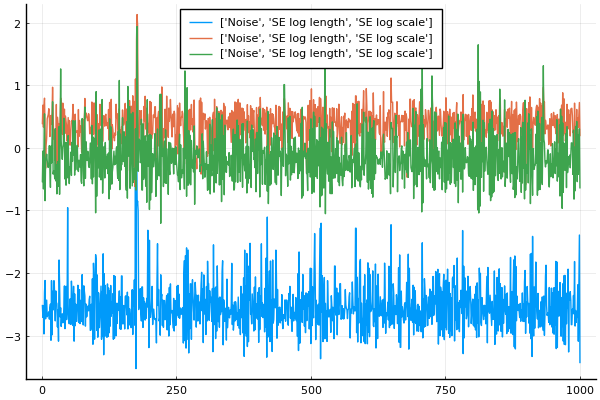

In [26]:
# estimate params using a Bayesian approach, i.e., instead of maximizing the log-
# loglikelihood, we approx the marginal posterior distribution using MCMC sampling

# assign priors to the mean and kernel params
using Distributions
set_priors!(kern, [Normal(0,1), Normal(0,1)]);

chain = mcmc(gp);

plot(chain', label=["Noise", "SE log length", "SE log scale"])